In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pydot
import os
import matplotlib.pyplot as plt
import copy
import time
from collections import Counter
import scene
import AllegroWrapper
import contact
import motion_planning
import search
import visualizations
from pydrake.all import StartMeshcat
from manipulation.utils import ConfigureParser

In [2]:
meshcat = None

In [114]:
p_W_brick = [0.65, -0.3, 0.015] #[np.random.uniform(0.4, 0.75), np.random.uniform(-0.35, 0.35), 0.01]
R_W_brick = [0, 0, np.random.randint(0, 360)]
meshcat, station, simulator, context, p_W_brick, R_W_brick = scene.init_scenario(brick_location=p_W_brick, brick_rotation=R_W_brick, meshcat=meshcat)

allegro = AllegroWrapper.AllegroHand(station, context)
simulator.set_target_realtime_rate(1.0)
x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
# scene.render_station_diagram(station)

def reset_arm(station, simulator, context, x0):
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

reset_arm(station, simulator, context, x0)

In [115]:
def investigate(simulator, station, p_W_obj, all_touched_points):
    """
    Given contact with an object, sample a number of contact locations nearby and 
    plan a trajectory with a finger to the object, in order to build up a point cloud
    of the object for pose estimation
    """
    context = simulator.get_mutable_context()    
    plant = station.GetSubsystemByName("plant")
    gripper = plant.GetBodyByName("link_2") # tip of the index finger
    plant_context = plant.GetMyContextFromRoot(context)

    def raise_hand(amount):
        iiwa_body = plant.GetBodyByName("iiwa_link_6")
        X_WG = plant.EvalBodyPoseInWorld(plant_context, iiwa_body)
        X_WG_desired = copy.deepcopy(X_WG)
        X_WG_desired.set_translation(X_WG.translation() + [0, 0, amount])
        obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(X_WG_desired.translation(), 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                frame="iiwa_link_6", 
                                                arc_height=0.0,
                                                stop_on_contact=True)
    
    #raise_hand(0.25)
    allegro.set_explore_mode()
    simulator.AdvanceTo(context.get_time() + 1)

    nearby_x = np.random.normal(p_W_obj[0], 0.05, 10)
    nearby_y = np.random.normal(p_W_obj[1], 0.05, 10)
    nearby_z = np.random.normal(p_W_obj[2], 0.05, 10)

    nearby_points = np.vstack((nearby_x, nearby_y, nearby_z)).T
    for point in nearby_points:
        obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(point, 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                frame="link_2", 
                                                arc_height=0.1,
                                                stop_on_contact=True, state_update_len=23)
        for contact in new_contacts:
            all_touched_points.add(tuple(contact))   

        raise_hand(0.15)
        simulator.AdvanceTo(context.get_time() + 1)
        
    return all_touched_points

In [116]:
def run_search(station, frame = "hand_root", object_bias=None):
    reset_arm(station, simulator, context, x0)
    plant = station.GetSubsystemByName("plant")
    all_touched_points = set()

    # Get initial pose of the gripper by using default context of manip station.
    gripper = plant.GetBodyByName(frame)
    plant_context = plant.GetMyContextFromRoot(context)
    
    X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)
    table_end_effector_poses = contact.get_table_contact(X_WG)
    p_WG_post = table_end_effector_poses[-1].translation()
       
    obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(p_WG_post, simulator, station, context, time_interval=0.4, frame=frame)
    touch_history = []

    if obj_touched == "table":
        table_height = min(new_contacts[:, 2])
        touched_point = new_contacts[np.random.choice(np.arange(len(new_contacts)))]
        print("Table height: ", table_height)
    else:
        print("Table not found")

    touch_history.append(touched_point[:2])
    for point in new_contacts:
        all_touched_points.add(tuple(point))

    i = 0
    while obj_touched != "object":
        if i > 30:
            break
        i += 1
        
        next_touch = search.sample_new_target(touch_history, bias_position=object_bias, object_radius=0.03)
        next_point = [next_touch[0], next_touch[1], table_height]
        touch_history.append(next_touch)
        
        #next_point = p_W_brick
        X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)

        # NOTE: This can change if there's biases in the search algorithm, based on the object's height and expected distance from the gripper
        # NOTE: We might also modify it based on some energy constraint, to minimize movement costs
        obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(next_point, 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                frame=frame, 
                                                arc_height=0.15)
                                                
        for point in new_contacts:
            all_touched_points.add(tuple(point))

        X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)
        #fig = visualizations.plot_2d_search(X_WG.translation(), all_touched_points, next_touch, object_bias, p_W_brick)
        #plt.show()

    print("Object found! Location at: ", p_W_obj)
    print("Actual object location: ", p_W_brick)
    print("Difference: ", np.linalg.norm(np.array(p_W_obj)[:2] - np.array(p_W_brick[:2])))
    return all_touched_points, p_W_obj

all_touched_points, object_contact = run_search(station, object_bias=[p_W_brick[0], p_W_brick[1]])

0.774116363851472
Table height:  -0.000546129027791319
0.015336683969959868
0.022488814833522816
Object found! Location at:  [ 0.63699149 -0.25810261  0.04871794]
Actual object location:  [0.65, -0.3, 0.015]
Difference:  0.043870409143647864


In [128]:
reset_arm(station, simulator, context, x0)

In [92]:
all_touched_points

{(0.5046366672701561, 0.1140568805671816, -0.0005461293225855722),
 (0.5048225624980727, 0.11268580134167645, -0.0005134505359551678),
 (0.5540449162538729, 0.06629355441160834, -0.0005187698382611138),
 (0.5632093291001625, 0.02338918247210161, -9.235200353522113e-05),
 (0.596075093899957, -0.02408811980162557, -0.0008644844413368338),
 (0.6050436784892271, -0.06700990080300123, -3.0193553530693043e-05),
 (0.6312328279716563, -0.2677584787920164, 0.04840738874405778),
 (0.7094020482108241, -0.06500153162170551, -1.571602567531586e-05)}

In [91]:
p_WC = np.array(list(all_touched_points))
p_WC[np.where(p_WC[:, 2] > 0.1)]

array([], shape=(0, 3), dtype=float64)

In [99]:
frame = "hand_root"
plant = station.GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(context)
current_pose = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName(frame))
pre_grasp_pose = object_contact + np.array([0., 0.0, 0.1])
print(current_pose.translation(), pre_grasp_pose)

allegro.set_positions(["thumb_revolute_z", "thumb_revolute_y", "thumb_1"], [1.2, 0.5, 0.5])
simulator.AdvanceTo(context.get_time() + 0.5)

obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(pre_grasp_pose, 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                frame=frame, 
                                                arc_height=0.02)


[ 0.46738026 -0.0043843   0.72526988] [ 0.63123283 -0.26775848  0.14840739]
0.5767478573217084


In [76]:
allegro.close_hand()
simulator.AdvanceTo(context.get_time() + 1)
                                            

In [129]:
all_touched_points = investigate(simulator,station, object_contact, all_touched_points)

0.25
1.1271763437319913
0.15000000000000002
1.0998367241249518
0.15
0.012701116026825596
0.15000000000000002
0.003163318747380406
0.15
0.005803772088017599
0.15000000000000002
0.0010409174521655573
0.14999999999999997
0.014102926525311546
0.15
0.011949163639131004
0.14999999999999997
0.03096634123583456
0.14999999999999997
0.024436933069754738
0.15000000000000002


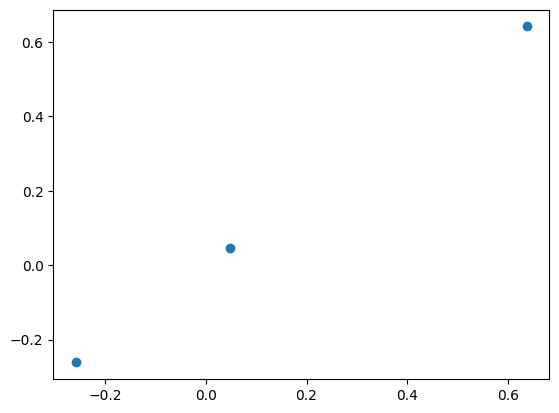

In [124]:
pc = np.array(list(all_touched_points))
box_points = pc[np.where(pc[:, 2] > 0.01)]
plt.scatter(box_points[0, :], box_points[1, :])